# Bank Marketing 

The aim here is to classify whether a client will subscribe to a term deposit plan or not. (Binary Classification)
Dataset url: https://www.kaggle.com/henriqueyamahata/bank-marketing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [60]:
## Performance 
### Hyper parameter tuning:

# xgboost : 0.9460779708783467
# RandomForestClassifier : 0.8956317519962423


### UP SAMPLING and One Hot encoding

# Catboost : 0.9428839830906529
# LightGBM : 0.9457022076092062


### No Up sampling and LabelEncoding

# Catboost : 0.9081063340991139
# LightGBM : 0.9043321299638989


### Voting Classifier ( Logistic Regression, KNN, Decision Tree Classifier)

## Accuracy : 0.9389384687646782

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [62]:
df = pd.read_csv('../../Data/bank-additional-full.csv', sep=';')

In [63]:
df.drop_duplicates(keep=False, inplace=True) 

In [7]:
columns = df.columns.tolist()
numerical = [feature for feature in columns if df[feature].dtypes!='O']
categorical = [feature for feature in columns if feature not in numerical]
polychotomus = [feature for feature in categorical if feature not in ['default','housing','loan','contact','y']]

## Preprocessing  

### Missing Values ( Unknown, 999 ) 

The Dataset contains missing values in categorical varaibles as "Unknown" and in numerical variables as "999" 

In [8]:
for feature in columns:
    df[feature] = np.where(df[feature]=='unknown',np.nan,df[feature])

In [9]:
## Missing values in Categorical

def Missing(df,columns):
    missing = []
    for feature in columns:
        missing_val = np.round(df[feature].isna().sum()/len(df), 3)*100
        missing.append([feature, missing_val])
    miss_df = pd.DataFrame(missing, columns=['Feature', '% Missing'])
    miss_df = miss_df[miss_df['% Missing'] != 0]
    return miss_df

In [10]:
Missing(df, columns)

,Feature,% Missing
1,job,0.8
2,marital,0.2
3,education,4.2
4,default,20.9
5,housing,2.4
6,loan,2.4


In [11]:
# Missing values in Numerical

count_999 = []
for feature in numerical:
    if (999 in df[feature].unique()):
        count_val = np.round((df[feature].value_counts()[999]/len(df[feature])),4)*100
        count_999.append([feature, count_val])
    else:
        pass
pd.DataFrame(count_999, columns=['Feature', '% Missing'])

,Feature,% Missing
0,duration,0.00
1,pdays,96.32


pdays and default have 96.32 and 20.9 percent missing values respectively hence need to drop these two columns. Also the rest of the columns having missing values, the rows have been dropped.

In [12]:
df.dropna(axis=0,inplace=True)

In [13]:
df.drop(['pdays','default'],axis=1, inplace=True)
columns.remove('pdays')
columns.remove('default')

In [14]:
numerical = [feature for feature in columns if df[feature].dtypes!='O']
categorical = [feature for feature in columns if feature not in numerical]
polychotomus = [feature for feature in categorical if feature not in ['housing','loan','contact','y']]

### Unique Values  

In [15]:
def unique(df, column):
    unique_vals = []
    for feature in column:
        val1 = df[feature].nunique()
        unique_vals.append([feature, val1])
    unique_df = pd.DataFrame(unique_vals, columns=['Feature', 'No. Unique'])

    return unique_df

In [16]:
## Numerical Variables Describe
def describe_num(df,numerical):
    vals = []
    for feature in numerical:
        feat_des = [feature, df[feature].nunique(),np.round(df[feature].mean(),2), min(df[feature]),
                    np.quantile(df[feature],0.25),np.quantile(df[feature],0.5),np.quantile(df[feature],0.75),
                    max(df[feature])]
        vals.append(feat_des)
    desc_num = pd.DataFrame(vals, columns=['Feature','No. Unique','Mean','Min','Q1','Q2','Q3','Max'])
    return desc_num

In [17]:
describe_num(df,numerical)

,Feature,No. Unique,Mean,Min,Q1,Q2,Q3,Max
0,age,76,39.03,17.000,31.000,37.000,45.000,95.000
1,duration,1441,259.54,0.000,103.000,181.000,321.000,4918.000
2,campaign,41,2.52,1.000,1.000,2.000,3.000,43.000
3,previous,8,0.19,0.000,0.000,0.000,0.000,7.000
4,emp.var.rate,10,-0.07,-3.400,-1.800,1.100,1.400,1.400
5,cons.price.idx,26,93.52,92.201,93.075,93.444,93.994,94.767
6,cons.conf.idx,26,-40.60,-50.800,-42.700,-41.800,-36.400,-26.900
7,euribor3m,314,3.46,0.634,1.313,4.856,4.961,5.045
8,nr.employed,11,5160.81,4963.600,5099.100,5191.000,5228.100,5228.100


In [18]:
unique(df, categorical)

,Feature,No. Unique
0,job,11
1,marital,3
2,education,7
3,housing,2
4,loan,2
5,contact,2
6,month,10
7,day_of_week,5
8,poutcome,3
9,y,2


## Exploratory Data Analysis 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


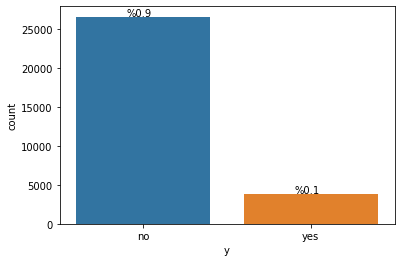

In [19]:
ax = sns.countplot(df['y'])
for p in ax.patches:
        ax.annotate('%{:.1f}'.format(np.round(p.get_height()/len(df),3)), (p.get_x()+0.3, p.get_height()+100))

Dataset is highly imbalanced 9:1

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


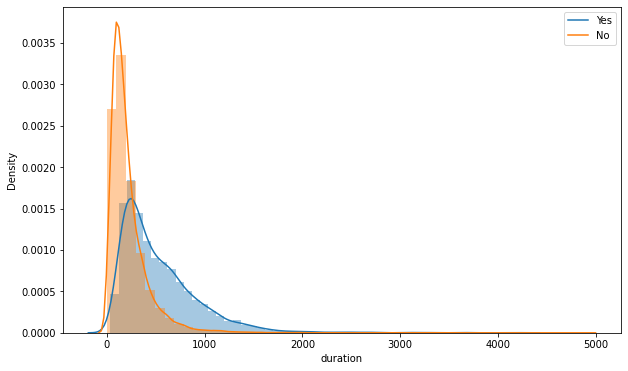

In [20]:
## Duration among the people who have and haven't agreed to the plan

plt.figure(figsize=(10,6))
sns.distplot(df[df['y']=='yes']['duration'])
sns.distplot(df[df['y']=='no']['duration'])
plt.legend(labels=['Yes','No'])
plt.show()

Clients who have agreed for a term deposit plan tend to have a larger duration of conversation. Probably to get to know more about the details of the term deposit plan. On the other hand, the clients who are not interested donot attend the call for a long duration

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


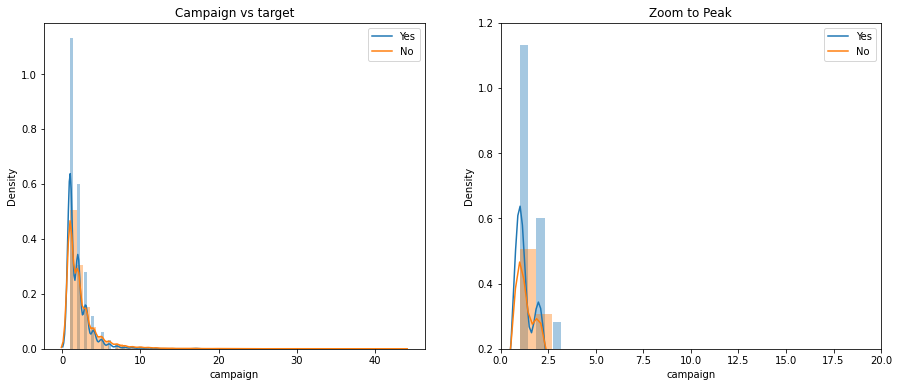

In [21]:
plt.figure(figsize=(15,6))


plt.subplot(1,2,1)
sns.distplot(df[df['y']=='yes']['campaign'])
sns.distplot(df[df['y']=='no']['campaign'])
plt.title('Campaign vs target')
plt.legend(labels=['Yes','No'])

plt.subplot(1,2,2)
sns.distplot(df[df['y']=='yes']['campaign'])
sns.distplot(df[df['y']=='no']['campaign'])
plt.title('Zoom to Peak')
plt.xlim([0,20])
plt.ylim([0.2,1.2])
plt.legend(labels=['Yes','No'])

plt.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


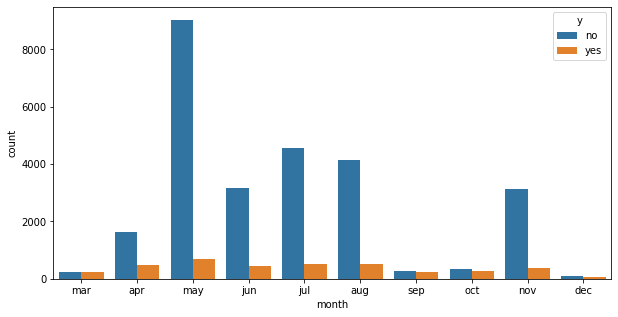

In [22]:
## Month 

plt.figure(figsize=(10,5))
sns.countplot(df['month'], order=['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], hue=df['y'])
plt.show()

Most Employees have been contacted in May followed by July, August and then June. The percent of people agreeing to a Term deposit plan are also significantly large as compared in other months. 

## Feature Engineering

### Feature Creation 

In [23]:
# Age Bin

def feat_creat(df):
    ## Age Binn
    age_bin = []
    for val in df['age']:
        if (val < 25):
            age_bin.append(0)
        elif (val>=25):
            age_bin.append(1)
    df['Age_Bin'] = age_bin

In [24]:
## Principal Component Analysis

pca = PCA(n_components=1)

pca.fit(df[numerical])
l1 = pca.transform(df[numerical])
df['PCA'] = l1

feat_creat(df)

### Encoding 

In [25]:
## Housing, Loan : Dichotomus (yes, no)

map_dichot = {'yes':1,'no':0}
for feature in ['housing','loan','y']:
    df[feature] = df[feature].map(map_dichot)

## Contact : Dichotomus (Telephone, cellular)
df['contact'] = df['contact'].map({'telephone':1,'cellular':0})


In [26]:
## df1 = label Encoding
## df2 = one hot encoding

df1 = df.copy()
df2 = df.copy()

In [27]:
## Label Encoding Polychotomus Features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [28]:
for feature in polychotomus:
    df1[feature] = le.fit_transform(df1[feature])

In [29]:
## One Hot Encoding Categorical Features

df2 = pd.get_dummies(df, columns=polychotomus, drop_first=True)

### Upsampling using Smote 

In [30]:
## Label Encoded variables

x1 = df1.drop(['y'],axis=1)
y1 = df1['y']

In [31]:
## One Hot Encoded Variables

x2 = df2.drop(['y'],axis=1)
y2 = df2['y']

In [32]:
from imblearn.over_sampling import SMOTE

SMOTE_OBJ = SMOTE()
xu,yu = SMOTE_OBJ.fit_sample(x2,y2)### Imp note hereee 

## Modelling 

In [8]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import classification_report

In [48]:
xu = xu.drop(['age'], axis = 1)
xu['y'] = yu

In [49]:
xu

,housing,loan,contact,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,0,0,1,261.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
1,1,0,1,226.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,151.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
3,0,1,1,307.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,139.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53217,0,0,0,355.492699,2.492699,0.492699,-1.700000,94.122373,-39.314601,0.889796,...,0,0,0,0,0,1,0,0,0,1
53218,0,0,0,190.927291,2.570916,0.785458,-3.400000,92.477770,-27.586534,0.731782,...,0,0,0,0,0,0,0,0,0,1
53219,0,0,0,178.795294,2.000000,0.000000,-1.800000,92.936164,-48.835451,1.465387,...,0,0,0,0,0,0,0,1,0,1
53220,0,0,0,663.919900,3.000000,0.000000,-1.788501,93.896583,-39.977002,0.703600,...,0,0,0,0,0,0,0,1,0,1


In [37]:
### UP SAMPLING TRAIN TEST SPLIT

x_train,x_test,y_train,y_test = train_test_split(xu,yu,test_size=0.2,random_state=42)

### Random Forest  and XGBoost Hyperparameter tuning 

#### XGBoost 

In [38]:
## XGB

xgb = XGBClassifier()

param_grid = dict(learning_rate = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                  boosting_type=['gbdt','dart','goss','rf'],
                 n_estimators=[100, 200, 350, 400])
xgb_ran = RandomizedSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

In [39]:
xgb_ran.fit(x_train, y_train)

[21:03:14] WARNING: ../src/learner.cc:516: 
Parameters: { boosting_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [40]:
xgb_ran.score(x_test, y_test)

0.9440112728980742

In [41]:
print(xgb_ran.best_params_)

{'n_estimators': 200, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}


In [43]:
pred_xgb = xgb_ran.predict(x_test)

In [44]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5278
           1       0.95      0.94      0.94      5367

    accuracy                           0.94     10645
   macro avg       0.94      0.94      0.94     10645
weighted avg       0.94      0.94      0.94     10645



#### Random Forest 

In [45]:
## RFC

random_grid = {'n_estimators': [100,200,400,300],
               'max_features': ['auto','sqrt'],
               'max_depth': [1, 3, 5],
               'min_samples_split': [5,10,15]}

rfc_ran = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, 
                               n_iter = 7, cv = 5, random_state=42, n_jobs = -1)

In [46]:
rfc_ran.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=7,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [100, 200, 400, 300]},
                   random_state=42)

In [47]:
print(rfc_ran.best_params_)

{'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 5}


In [49]:
rfc_ran.score(x_test, y_test)

0.8962893377172382

In [50]:
pred_rfc = rfc_ran.predict(x_test)
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      5278
           1       0.86      0.95      0.90      5367

    accuracy                           0.90     10645
   macro avg       0.90      0.90      0.90     10645
weighted avg       0.90      0.90      0.90     10645



### Upsampling and One Hot Encoding

#### Catboost  

In [51]:
## cat boost upsampling

cat = CatBoostClassifier()
cat.fit(x_train,y_train)

Learning rate set to 0.05112
0:	learn: 0.6404994	total: 81ms	remaining: 1m 20s
1:	learn: 0.5966535	total: 99.8ms	remaining: 49.8s
2:	learn: 0.5554638	total: 116ms	remaining: 38.5s
3:	learn: 0.5227641	total: 134ms	remaining: 33.3s
4:	learn: 0.4928605	total: 156ms	remaining: 31s
5:	learn: 0.4678950	total: 174ms	remaining: 28.8s
6:	learn: 0.4449188	total: 194ms	remaining: 27.5s
7:	learn: 0.4263852	total: 213ms	remaining: 26.4s
8:	learn: 0.4098455	total: 230ms	remaining: 25.4s
9:	learn: 0.3873787	total: 247ms	remaining: 24.4s
10:	learn: 0.3694794	total: 265ms	remaining: 23.8s
11:	learn: 0.3554992	total: 282ms	remaining: 23.2s
12:	learn: 0.3469242	total: 301ms	remaining: 22.9s
13:	learn: 0.3380451	total: 320ms	remaining: 22.5s
14:	learn: 0.3296370	total: 338ms	remaining: 22.2s
15:	learn: 0.3186301	total: 356ms	remaining: 21.9s
16:	learn: 0.3125551	total: 373ms	remaining: 21.6s
17:	learn: 0.3066860	total: 390ms	remaining: 21.3s
18:	learn: 0.3008832	total: 410ms	remaining: 21.2s
19:	learn: 0.

164:	learn: 0.1360117	total: 2.94s	remaining: 14.9s
165:	learn: 0.1359238	total: 2.96s	remaining: 14.9s
166:	learn: 0.1355969	total: 2.98s	remaining: 14.9s
167:	learn: 0.1353950	total: 3s	remaining: 14.8s
168:	learn: 0.1352376	total: 3.01s	remaining: 14.8s
169:	learn: 0.1351435	total: 3.03s	remaining: 14.8s
170:	learn: 0.1350394	total: 3.05s	remaining: 14.8s
171:	learn: 0.1349229	total: 3.06s	remaining: 14.8s
172:	learn: 0.1348226	total: 3.08s	remaining: 14.7s
173:	learn: 0.1345737	total: 3.1s	remaining: 14.7s
174:	learn: 0.1344610	total: 3.12s	remaining: 14.7s
175:	learn: 0.1343597	total: 3.13s	remaining: 14.7s
176:	learn: 0.1342704	total: 3.15s	remaining: 14.7s
177:	learn: 0.1341221	total: 3.17s	remaining: 14.6s
178:	learn: 0.1339583	total: 3.18s	remaining: 14.6s
179:	learn: 0.1338434	total: 3.2s	remaining: 14.6s
180:	learn: 0.1334975	total: 3.22s	remaining: 14.6s
181:	learn: 0.1333998	total: 3.24s	remaining: 14.6s
182:	learn: 0.1332562	total: 3.26s	remaining: 14.6s
183:	learn: 0.133

328:	learn: 0.1167273	total: 5.84s	remaining: 11.9s
329:	learn: 0.1166445	total: 5.86s	remaining: 11.9s
330:	learn: 0.1165673	total: 5.88s	remaining: 11.9s
331:	learn: 0.1165001	total: 5.9s	remaining: 11.9s
332:	learn: 0.1164462	total: 5.92s	remaining: 11.8s
333:	learn: 0.1163625	total: 5.93s	remaining: 11.8s
334:	learn: 0.1162923	total: 5.95s	remaining: 11.8s
335:	learn: 0.1162140	total: 5.97s	remaining: 11.8s
336:	learn: 0.1161333	total: 5.99s	remaining: 11.8s
337:	learn: 0.1160572	total: 6s	remaining: 11.8s
338:	learn: 0.1159848	total: 6.02s	remaining: 11.7s
339:	learn: 0.1158858	total: 6.04s	remaining: 11.7s
340:	learn: 0.1157512	total: 6.06s	remaining: 11.7s
341:	learn: 0.1156500	total: 6.08s	remaining: 11.7s
342:	learn: 0.1155997	total: 6.09s	remaining: 11.7s
343:	learn: 0.1154906	total: 6.11s	remaining: 11.7s
344:	learn: 0.1154319	total: 6.13s	remaining: 11.6s
345:	learn: 0.1153321	total: 6.14s	remaining: 11.6s
346:	learn: 0.1152256	total: 6.16s	remaining: 11.6s
347:	learn: 0.11

497:	learn: 0.1045655	total: 8.76s	remaining: 8.83s
498:	learn: 0.1045024	total: 8.77s	remaining: 8.81s
499:	learn: 0.1044502	total: 8.79s	remaining: 8.79s
500:	learn: 0.1041711	total: 8.81s	remaining: 8.77s
501:	learn: 0.1040685	total: 8.82s	remaining: 8.75s
502:	learn: 0.1040389	total: 8.84s	remaining: 8.73s
503:	learn: 0.1039785	total: 8.86s	remaining: 8.71s
504:	learn: 0.1039134	total: 8.87s	remaining: 8.7s
505:	learn: 0.1038581	total: 8.89s	remaining: 8.68s
506:	learn: 0.1037972	total: 8.91s	remaining: 8.66s
507:	learn: 0.1037390	total: 8.93s	remaining: 8.65s
508:	learn: 0.1036672	total: 8.94s	remaining: 8.63s
509:	learn: 0.1036054	total: 8.96s	remaining: 8.61s
510:	learn: 0.1035568	total: 8.98s	remaining: 8.59s
511:	learn: 0.1034929	total: 8.99s	remaining: 8.57s
512:	learn: 0.1032968	total: 9.01s	remaining: 8.55s
513:	learn: 0.1032232	total: 9.03s	remaining: 8.54s
514:	learn: 0.1031576	total: 9.04s	remaining: 8.52s
515:	learn: 0.1030966	total: 9.06s	remaining: 8.5s
516:	learn: 0.

658:	learn: 0.0957562	total: 11.7s	remaining: 6.04s
659:	learn: 0.0957205	total: 11.7s	remaining: 6.03s
660:	learn: 0.0956582	total: 11.7s	remaining: 6.01s
661:	learn: 0.0956085	total: 11.7s	remaining: 5.99s
662:	learn: 0.0955453	total: 11.8s	remaining: 5.97s
663:	learn: 0.0954746	total: 11.8s	remaining: 5.96s
664:	learn: 0.0954426	total: 11.8s	remaining: 5.94s
665:	learn: 0.0954043	total: 11.8s	remaining: 5.92s
666:	learn: 0.0953690	total: 11.8s	remaining: 5.9s
667:	learn: 0.0953362	total: 11.8s	remaining: 5.88s
668:	learn: 0.0953070	total: 11.9s	remaining: 5.87s
669:	learn: 0.0952433	total: 11.9s	remaining: 5.85s
670:	learn: 0.0952261	total: 11.9s	remaining: 5.83s
671:	learn: 0.0951632	total: 11.9s	remaining: 5.81s
672:	learn: 0.0951011	total: 11.9s	remaining: 5.79s
673:	learn: 0.0950099	total: 11.9s	remaining: 5.78s
674:	learn: 0.0949312	total: 12s	remaining: 5.76s
675:	learn: 0.0948705	total: 12s	remaining: 5.74s
676:	learn: 0.0947427	total: 12s	remaining: 5.72s
677:	learn: 0.09469

826:	learn: 0.0885090	total: 14.6s	remaining: 3.06s
827:	learn: 0.0884742	total: 14.6s	remaining: 3.04s
828:	learn: 0.0884435	total: 14.7s	remaining: 3.02s
829:	learn: 0.0884115	total: 14.7s	remaining: 3s
830:	learn: 0.0883690	total: 14.7s	remaining: 2.99s
831:	learn: 0.0883351	total: 14.7s	remaining: 2.97s
832:	learn: 0.0882998	total: 14.7s	remaining: 2.95s
833:	learn: 0.0882762	total: 14.7s	remaining: 2.93s
834:	learn: 0.0882545	total: 14.8s	remaining: 2.92s
835:	learn: 0.0882237	total: 14.8s	remaining: 2.9s
836:	learn: 0.0881851	total: 14.8s	remaining: 2.88s
837:	learn: 0.0881409	total: 14.8s	remaining: 2.86s
838:	learn: 0.0881144	total: 14.8s	remaining: 2.85s
839:	learn: 0.0880982	total: 14.8s	remaining: 2.83s
840:	learn: 0.0880650	total: 14.9s	remaining: 2.81s
841:	learn: 0.0880264	total: 14.9s	remaining: 2.79s
842:	learn: 0.0879817	total: 14.9s	remaining: 2.77s
843:	learn: 0.0879415	total: 14.9s	remaining: 2.75s
844:	learn: 0.0879159	total: 14.9s	remaining: 2.74s
845:	learn: 0.08

990:	learn: 0.0827473	total: 17.8s	remaining: 161ms
991:	learn: 0.0827122	total: 17.8s	remaining: 143ms
992:	learn: 0.0826794	total: 17.8s	remaining: 125ms
993:	learn: 0.0826370	total: 17.8s	remaining: 108ms
994:	learn: 0.0825987	total: 17.8s	remaining: 89.7ms
995:	learn: 0.0825796	total: 17.9s	remaining: 71.8ms
996:	learn: 0.0825607	total: 17.9s	remaining: 53.8ms
997:	learn: 0.0825008	total: 17.9s	remaining: 35.9ms
998:	learn: 0.0824834	total: 17.9s	remaining: 17.9ms
999:	learn: 0.0824659	total: 17.9s	remaining: 0us


In [52]:
cat.score(x_test, y_test)

0.9436355096289337

In [53]:
pred_cat = cat.predict(x_test)
print(classification_report(y_test, pred_cat))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5278
           1       0.95      0.94      0.94      5367

    accuracy                           0.94     10645
   macro avg       0.94      0.94      0.94     10645
weighted avg       0.94      0.94      0.94     10645



#### LGBM 

In [54]:
lgb = LGBMClassifier()
lgb.fit(x_train, y_train)

LGBMClassifier()

In [55]:
lgb.score(x_test, y_test)

0.9456082667919211

In [56]:
pred_lgb = lgb.predict(x_test)
print(classification_report(y_test, pred_lgb))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5278
           1       0.95      0.94      0.95      5367

    accuracy                           0.95     10645
   macro avg       0.95      0.95      0.95     10645
weighted avg       0.95      0.95      0.95     10645



In [57]:
lgb_featimp = pd.DataFrame(lgb.feature_importances_, index=x_train.columns).sort_values(by=0,ascending=False)

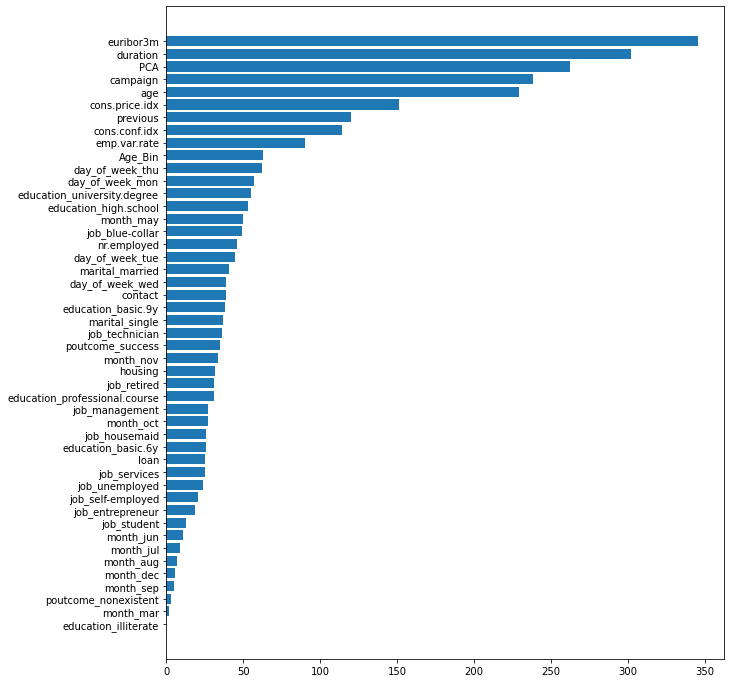

In [58]:
## Feature importance LGBM

plt.figure(figsize=(10,12))
sort_lgb = lgb.feature_importances_.argsort()
plt.barh(x_train.columns[sort_lgb], lgb.feature_importances_[sort_lgb])
plt.show()

#### Voting Classifier 

In [59]:
estimator = [] 
estimator.append(('LR',  
                  LogisticRegression(max_iter = 10000))) 
estimator.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ))) 
estimator.append(('DTC', DecisionTreeClassifier())) 

In [60]:
vot_soft = VotingClassifier(estimators = estimator, voting ='soft') 

In [61]:
vot_soft.fit(x_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(max_iter=10000)),
                             ('KNN', KNeighborsClassifier()),
                             ('DTC', DecisionTreeClassifier())],
                 voting='soft')

In [62]:
vot_soft.score(x_test, y_test)

0.9368717707844059

In [63]:
pred_vot_soft = vot_soft.predict(x_test)
print(classification_report(y_test, pred_vot_soft))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5278
           1       0.92      0.96      0.94      5367

    accuracy                           0.94     10645
   macro avg       0.94      0.94      0.94     10645
weighted avg       0.94      0.94      0.94     10645



### No upsampling technique used and Label Encoded

In [64]:

x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.2,random_state=42)

#### Catboost 

In [65]:
cat.fit(x1_train, y1_train)

Learning rate set to 0.040286
0:	learn: 0.6195727	total: 13.7ms	remaining: 13.7s
1:	learn: 0.5658136	total: 26.3ms	remaining: 13.1s
2:	learn: 0.5240560	total: 39ms	remaining: 13s
3:	learn: 0.4894272	total: 50.8ms	remaining: 12.6s
4:	learn: 0.4535505	total: 63.6ms	remaining: 12.7s
5:	learn: 0.4281995	total: 76.3ms	remaining: 12.6s
6:	learn: 0.4049760	total: 89.8ms	remaining: 12.7s
7:	learn: 0.3813578	total: 104ms	remaining: 12.9s
8:	learn: 0.3614208	total: 118ms	remaining: 13s
9:	learn: 0.3475701	total: 129ms	remaining: 12.8s
10:	learn: 0.3333573	total: 140ms	remaining: 12.6s
11:	learn: 0.3230448	total: 152ms	remaining: 12.5s
12:	learn: 0.3123690	total: 164ms	remaining: 12.4s
13:	learn: 0.3016555	total: 175ms	remaining: 12.3s
14:	learn: 0.2927591	total: 189ms	remaining: 12.4s
15:	learn: 0.2832380	total: 202ms	remaining: 12.5s
16:	learn: 0.2754900	total: 216ms	remaining: 12.5s
17:	learn: 0.2711581	total: 232ms	remaining: 12.7s
18:	learn: 0.2671381	total: 246ms	remaining: 12.7s
19:	learn:

163:	learn: 0.1814157	total: 2.05s	remaining: 10.5s
164:	learn: 0.1813154	total: 2.06s	remaining: 10.4s
165:	learn: 0.1812691	total: 2.07s	remaining: 10.4s
166:	learn: 0.1811616	total: 2.09s	remaining: 10.4s
167:	learn: 0.1811021	total: 2.1s	remaining: 10.4s
168:	learn: 0.1809519	total: 2.11s	remaining: 10.4s
169:	learn: 0.1808526	total: 2.12s	remaining: 10.4s
170:	learn: 0.1808107	total: 2.14s	remaining: 10.4s
171:	learn: 0.1806901	total: 2.15s	remaining: 10.3s
172:	learn: 0.1806026	total: 2.16s	remaining: 10.3s
173:	learn: 0.1804721	total: 2.17s	remaining: 10.3s
174:	learn: 0.1804046	total: 2.19s	remaining: 10.3s
175:	learn: 0.1803293	total: 2.2s	remaining: 10.3s
176:	learn: 0.1802330	total: 2.21s	remaining: 10.3s
177:	learn: 0.1801572	total: 2.22s	remaining: 10.2s
178:	learn: 0.1800404	total: 2.23s	remaining: 10.2s
179:	learn: 0.1799492	total: 2.24s	remaining: 10.2s
180:	learn: 0.1798237	total: 2.26s	remaining: 10.2s
181:	learn: 0.1797467	total: 2.27s	remaining: 10.2s
182:	learn: 0.

329:	learn: 0.1684631	total: 4.1s	remaining: 8.32s
330:	learn: 0.1684276	total: 4.11s	remaining: 8.31s
331:	learn: 0.1683707	total: 4.12s	remaining: 8.29s
332:	learn: 0.1683214	total: 4.13s	remaining: 8.28s
333:	learn: 0.1682523	total: 4.15s	remaining: 8.27s
334:	learn: 0.1681737	total: 4.16s	remaining: 8.26s
335:	learn: 0.1681018	total: 4.17s	remaining: 8.24s
336:	learn: 0.1680874	total: 4.18s	remaining: 8.23s
337:	learn: 0.1680238	total: 4.2s	remaining: 8.22s
338:	learn: 0.1679373	total: 4.21s	remaining: 8.21s
339:	learn: 0.1678793	total: 4.22s	remaining: 8.19s
340:	learn: 0.1678116	total: 4.23s	remaining: 8.18s
341:	learn: 0.1677290	total: 4.24s	remaining: 8.16s
342:	learn: 0.1676323	total: 4.25s	remaining: 8.15s
343:	learn: 0.1675838	total: 4.26s	remaining: 8.13s
344:	learn: 0.1675267	total: 4.28s	remaining: 8.12s
345:	learn: 0.1674688	total: 4.29s	remaining: 8.11s
346:	learn: 0.1674579	total: 4.3s	remaining: 8.1s
347:	learn: 0.1673961	total: 4.31s	remaining: 8.08s
348:	learn: 0.16

493:	learn: 0.1579551	total: 6.14s	remaining: 6.29s
494:	learn: 0.1578990	total: 6.16s	remaining: 6.28s
495:	learn: 0.1578628	total: 6.17s	remaining: 6.26s
496:	learn: 0.1578014	total: 6.18s	remaining: 6.25s
497:	learn: 0.1577210	total: 6.19s	remaining: 6.24s
498:	learn: 0.1576976	total: 6.2s	remaining: 6.22s
499:	learn: 0.1576389	total: 6.21s	remaining: 6.21s
500:	learn: 0.1575704	total: 6.22s	remaining: 6.2s
501:	learn: 0.1575185	total: 6.24s	remaining: 6.18s
502:	learn: 0.1574662	total: 6.25s	remaining: 6.17s
503:	learn: 0.1574247	total: 6.26s	remaining: 6.16s
504:	learn: 0.1573536	total: 6.27s	remaining: 6.15s
505:	learn: 0.1572890	total: 6.28s	remaining: 6.13s
506:	learn: 0.1572605	total: 6.3s	remaining: 6.12s
507:	learn: 0.1572442	total: 6.31s	remaining: 6.11s
508:	learn: 0.1572131	total: 6.32s	remaining: 6.1s
509:	learn: 0.1571526	total: 6.33s	remaining: 6.08s
510:	learn: 0.1571423	total: 6.34s	remaining: 6.07s
511:	learn: 0.1570754	total: 6.36s	remaining: 6.06s
512:	learn: 0.15

664:	learn: 0.1486888	total: 8.21s	remaining: 4.13s
665:	learn: 0.1486333	total: 8.22s	remaining: 4.13s
666:	learn: 0.1485798	total: 8.24s	remaining: 4.11s
667:	learn: 0.1485317	total: 8.25s	remaining: 4.1s
668:	learn: 0.1485055	total: 8.26s	remaining: 4.09s
669:	learn: 0.1484442	total: 8.28s	remaining: 4.08s
670:	learn: 0.1483846	total: 8.29s	remaining: 4.06s
671:	learn: 0.1483356	total: 8.3s	remaining: 4.05s
672:	learn: 0.1482936	total: 8.31s	remaining: 4.04s
673:	learn: 0.1482272	total: 8.32s	remaining: 4.03s
674:	learn: 0.1481877	total: 8.33s	remaining: 4.01s
675:	learn: 0.1481334	total: 8.35s	remaining: 4s
676:	learn: 0.1480810	total: 8.36s	remaining: 3.99s
677:	learn: 0.1480349	total: 8.37s	remaining: 3.97s
678:	learn: 0.1480267	total: 8.38s	remaining: 3.96s
679:	learn: 0.1479773	total: 8.39s	remaining: 3.95s
680:	learn: 0.1479082	total: 8.4s	remaining: 3.94s
681:	learn: 0.1478514	total: 8.41s	remaining: 3.92s
682:	learn: 0.1477904	total: 8.42s	remaining: 3.91s
683:	learn: 0.1477

831:	learn: 0.1406805	total: 10.2s	remaining: 2.07s
832:	learn: 0.1406328	total: 10.3s	remaining: 2.06s
833:	learn: 0.1405866	total: 10.3s	remaining: 2.04s
834:	learn: 0.1405460	total: 10.3s	remaining: 2.03s
835:	learn: 0.1404763	total: 10.3s	remaining: 2.02s
836:	learn: 0.1404347	total: 10.3s	remaining: 2.01s
837:	learn: 0.1404058	total: 10.3s	remaining: 2s
838:	learn: 0.1403523	total: 10.3s	remaining: 1.98s
839:	learn: 0.1403430	total: 10.3s	remaining: 1.97s
840:	learn: 0.1403004	total: 10.4s	remaining: 1.96s
841:	learn: 0.1402576	total: 10.4s	remaining: 1.95s
842:	learn: 0.1402400	total: 10.4s	remaining: 1.93s
843:	learn: 0.1402018	total: 10.4s	remaining: 1.92s
844:	learn: 0.1401442	total: 10.4s	remaining: 1.91s
845:	learn: 0.1400803	total: 10.4s	remaining: 1.9s
846:	learn: 0.1400326	total: 10.4s	remaining: 1.88s
847:	learn: 0.1399693	total: 10.4s	remaining: 1.87s
848:	learn: 0.1399530	total: 10.5s	remaining: 1.86s
849:	learn: 0.1399103	total: 10.5s	remaining: 1.85s
850:	learn: 0.13

In [66]:
print("Accuracy : ", cat.score(x1_test, y1_test),"\n")
print(classification_report(y1_test, cat.predict(x1_test)))


Accuracy :  0.9081063340991139 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5302
           1       0.67      0.57      0.62       792

    accuracy                           0.91      6094
   macro avg       0.81      0.76      0.78      6094
weighted avg       0.90      0.91      0.90      6094



#### LGBM

In [67]:
lgb.fit(x1_train, y1_train)

LGBMClassifier()

In [68]:
print("Accuracy : ", lgb.score(x1_test, y1_test),"\n")
print(classification_report(y1_test, lgb.predict(x1_test)))

Accuracy :  0.9085986215950115 

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5302
           1       0.68      0.56      0.62       792

    accuracy                           0.91      6094
   macro avg       0.81      0.76      0.78      6094
weighted avg       0.90      0.91      0.90      6094



In [69]:
### Hyper parameter tuning:

# xgboost : 0.9460779708783467
# RandomForestClassifier : 0.8956317519962423


### UP SAMPLING and One Hot encoding

# Catboost : 0.9428839830906529
# LightGBM : 0.9457022076092062


### No Up sampling and LabelEncoding

# Catboost : 0.9081063340991139
# LightGBM : 0.9043321299638989


### Voting Classifier ( Logistic Regression, KNN, Decision Tree Classifier)

## Accuracy : 0.9389384687646782

## Fairness

In [3]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [4]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [5]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [53]:
xu

,housing,loan,contact,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,0,0,1,261.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
1,1,0,1,226.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,151.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
3,0,1,1,307.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,139.000000,1.000000,0.000000,1.100000,93.994000,-36.400000,4.857000,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53217,0,0,0,355.492699,2.492699,0.492699,-1.700000,94.122373,-39.314601,0.889796,...,0,0,0,0,0,1,0,0,0,1
53218,0,0,0,190.927291,2.570916,0.785458,-3.400000,92.477770,-27.586534,0.731782,...,0,0,0,0,0,0,0,0,0,1
53219,0,0,0,178.795294,2.000000,0.000000,-1.800000,92.936164,-48.835451,1.465387,...,0,0,0,0,0,0,0,1,0,1
53220,0,0,0,663.919900,3.000000,0.000000,-1.788501,93.896583,-39.977002,0.703600,...,0,0,0,0,0,0,0,1,0,1


In [54]:
privileged_groups = [{'Age_Bin': 1}]
unprivileged_groups = [{'Age_Bin': 0}]
dataset_orig = StandardDataset(xu,
                                  label_name='y',
                                  protected_attribute_names=['Age_Bin'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])

In [55]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.253194


In [6]:
data_orig_train = pd.read_pickle('../../Results/VotingClassifier/2-bank-marketing_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/VotingClassifier/2-bank-marketing_Test.pkl')

In [9]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import pickle

#data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

estimators = [] 
estimators.append(('LR',  
                  LogisticRegression(max_iter = 10000))) 
estimators.append(('KNN', KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ))) 
estimators.append(('DTC', DecisionTreeClassifier(random_state=12))) 


votingC = VotingClassifier(estimators, voting ='soft')

model = votingC.fit(X_train, y_train)


mdl = model.fit(X_train, y_train)
#with open('../../Results/VotingClassifier/' + nb_fname + '.pkl', 'wb') as f:
#    pickle.dump(mdl, f)

#with open('../../Results/VotingClassifier/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_train, f) 
    
#with open('../../Results/VotingClassifier/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_test, f) 

In [14]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    #print(list_estimators)
    model = VotingClassifier(estimators=list_estimators, voting='soft')
    list_estimators = []
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)        
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [16]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
#final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
#final_result.to_csv('../../Results/VotingClassifier/' + nb_fname + '.csv')
final_result

,T0,T1,T2
accuracy,0.926661,0.899856,0.924782
f1,0.925674,0.905958,0.924660
statistical_parity_difference,0.272812,0.249866,0.247101
equal_opportunity_difference,0.035333,0.018953,0.028482
average_abs_odds_difference,0.076725,0.072548,0.036362
disparate_impact,0.452895,0.371422,0.408912
theil_index,0.053537,0.042334,0.050673
